# Library

In [19]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

from ignite.metrics import mIoU
from torchmetrics.classification import ConfusionMatrix

import numpy as np
import os
# import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt
import pandas as pd
from collections import namedtuple
from sklearn.metrics import accuracy_score
# import rasterio
from copy import deepcopy
from sklearn.model_selection import train_test_split

In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Dataset

In [21]:
RANDOM_STATE = 42

# Train

### Data load

In [22]:
from sklearn.model_selection import train_test_split
from dataset import CustomDataset
from torch.utils.data import Dataset, DataLoader
import multiprocessing 
#multiprocessing.set_start_method('spawn')
BASE = '.'
train_meta = pd.read_csv(f'{BASE}/train_meta.csv').sample(n=15000,random_state=RANDOM_STATE)
test_meta = pd.read_csv(f'{BASE}/test_meta.csv')

# 데이터 위치
IMAGES_PATH = f'{BASE}/train_img/'
MASKS_PATH = f'{BASE}/train_mask/'

# 가중치 저장 위치
SAVE_PATH = f'{BASE}/train_output/'
MODEL_SAVE = f'{SAVE_PATH}/best_UNet_Base_model.pth'

# train : val = 8 : 2 나누기
x_tr, x_val = train_test_split(train_meta, test_size=0.2, random_state=RANDOM_STATE)

# train : val
images_train = [os.path.join(IMAGES_PATH, image) for image in x_tr['train_img'] ]
masks_train = [os.path.join(MASKS_PATH, mask) for mask in x_tr['train_mask'] ]

images_valid = [os.path.join(IMAGES_PATH, image) for image in x_val['train_img'] ]
masks_valid = [os.path.join(MASKS_PATH, mask) for mask in x_val['train_mask'] ]

WORKERS = 4
BATCH_SIZE = 32
train_dataset = CustomDataset(images_train, masks_train, mode='train')
valid_dataset = CustomDataset(images_valid, masks_valid, mode='valid')

train_dataloader = DataLoader(
   dataset=train_dataset,
   batch_size=BATCH_SIZE,
   shuffle=True,
   num_workers=WORKERS,
   pin_memory=True
)

val_dataloader = DataLoader(
   dataset=valid_dataset,
   batch_size=BATCH_SIZE,
   shuffle=False,
   num_workers=WORKERS,
   pin_memory=True
)

In [23]:
# train_transforms = transforms.Compose([
#             transforms.ToTensor(),
#         ])
# val_transforms = transforms.Compose([
#             transforms.ToTensor(),
#         ])

In [24]:
#WORKERS = 0 #
EPOCHS = 100 # 훈련 epoch 지정
BATCH_SIZE = 16 # batch size 지정
IMAGE_SIZE = (256, 256) # 이미지 크기 지정

# MAX_NORM = 3
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

seed_everything(RANDOM_STATE) # SEED 고정

cuda


### Model train

#### model selection

In [25]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice 

In [42]:
# torch init cache
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [27]:
def calculate_iou(y_true, y_pred):
    """
    한 클래스에 대한 IoU를 계산합니다.
    """
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_miou(y_true, y_pred):
    """
    산불이 있는 경우와 없는 경우, 두 클래스에 대한 평균 IoU(mIoU)를 계산합니다.
    """
    y_pred = F.sigmoid(y_pred)
    y_pred = np.where(y_pred > 0.2, 1, 0) # 임계값 처리
    iou_fire = calculate_iou(y_true == 1, y_pred == 1)
    
    # 두 클래스에 대한 IoU 평균 계산
    return iou_fire

In [28]:
import segmentation_models_pytorch as smp
model = smp.PAN('timm-efficientnet-b3', encoder_weights='imagenet',  classes=1, activation=None,in_channels=1)#, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
#model.load_state_dict(torch.load(MODEL_SAVE))

<All keys matched successfully>

In [29]:
#model = smp.DeepLabV3Plus('resnet34', encoder_weights='imagenet',classes=1, activation='sigmoid',in_channels = 1)

In [30]:
# model = smp.Unet(encoder_name='efficientnet-b0',encoder_weights ='imagenet',in_channels=10, classes=1,activation='sigmoid',)
# weight_decay = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=0.001)#(params=model.parameters(), lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)
# loss_fn = DiceLoss().to(DEVICE)

In [31]:
# loss_fn = torchvision.ops.sigmoid_focal_loss

In [32]:
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.000001)

In [33]:
def pixel_accuracy (y_true, y_pred):
    low = np.quantile(y_pred, 0.99)
    y_pred = np.where(y_pred >  low, 1, 0) # 임계값 처리
    sum_n = np.sum(np.logical_and(y_pred, y_true))
    sum_t = np.sum(y_true)

    if (sum_t == 0):
        pixel_accuracy = 0
    else:
        pixel_accuracy = sum_n / sum_t
    return pixel_accuracy

In [34]:
best_val_loss = 1e9
best_model = None
early_stop = 0

model.to(DEVICE)
print('Train START')
for epoch in range(1, EPOCHS+1):
    model.train()
    print('Epoch {}/{}'.format(epoch, EPOCHS))
    print('-'*20)
    train_loss, train_accs, train_ious = 0, [], []

    #### train ####
    for imgs, masks in tqdm(train_dataloader):
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()  # 초기화
        output = model(imgs)  # 예측
        loss = loss_fn(output, masks)  # 순전파

        loss.backward()  # 역전파
        optimizer.step()  # 학습
        
        iou = calculate_miou(masks.cpu().detach().numpy(), output.cpu())
        output = output.cpu().detach().numpy()
        masks = masks.cpu().detach().numpy()
        accuracy = pixel_accuracy(masks, output)  # mIou
        train_accs.append(accuracy)
        train_ious.append(iou)
        train_loss += loss.item()

    #### valid ####
    model.eval()
    val_loss, val_accs, val_ious = 0, [], []
    with torch.no_grad():
        for imgs, masks in tqdm(val_dataloader):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            output = model(imgs)  # 예측

            loss = loss_fn(output, masks)  # 순전파
            iou = calculate_miou(masks.cpu().detach().numpy(), output.cpu())
            output = output.cpu().detach().numpy()
            masks = masks.cpu().detach().numpy()
            accuracy = pixel_accuracy(masks, output)  # mIou
            val_accs.append(accuracy)
            val_ious.append(iou)
            val_loss += loss.item()

    train_acc = np.mean(train_accs)
    train_iou = np.mean(train_ious)
    val_acc = np.mean(val_accs)
    val_iou = np.mean(val_ious)
    val_loss /= len(val_dataloader)  # 평균 계산

    print(f"EPOCH: {epoch}, TRAIN LOSS: {train_loss:.6f}, TRAIN mIou: {train_iou:.6f}, TRAIN ACC: {train_acc:.6f}, VAL LOSS: {val_loss:.6f}, VAL mIou: {val_iou:.6f}, VAL ACC: {val_acc:.6f}")

    if lr_scheduler is not None:
        lr_scheduler.step(val_loss)

    if best_val_loss > val_loss:
        print("Model Save")
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE)
        early_stop = 0
    else:
        early_stop += 1

    # early stop
    if early_stop > 10:
        print("Early Stop")
        break

Train START
Epoch 1/100
--------------------


C:\Users\승범 pc\AppData\Local\Temp\ipykernel_18272\3063354036.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for imgs, masks in tqdm(train_dataloader):


  0%|          | 0/375 [00:00<?, ?it/s]

KeyboardInterrupt: 

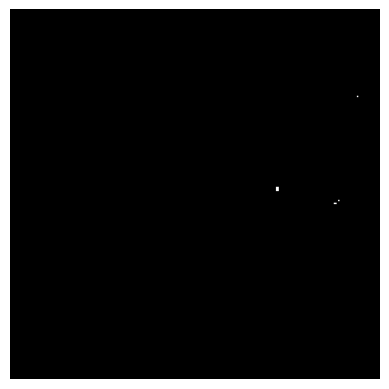

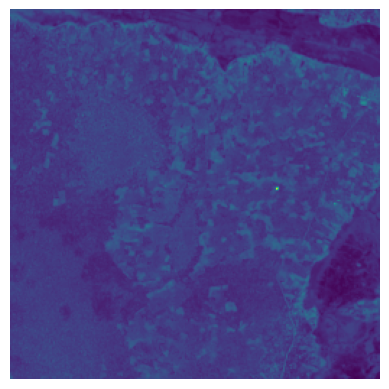

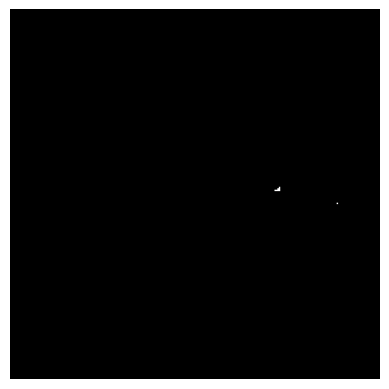

[0. 1.]
a:(array([ 60, 123, 123, 124, 124, 125, 125, 132, 134, 134], dtype=int64), array([240, 184, 185, 184, 185, 184, 185, 227, 224, 225], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))
b:(array([123, 124, 124, 125, 125, 125, 125, 134], dtype=int64), array([186, 185, 186, 183, 184, 185, 186, 226], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))


In [41]:
NUM = 4

import numpy as np
import matplotlib.pyplot as plt
with torch.no_grad():
    masksx = masks[NUM].cpu().detach().numpy()
    masksx = np.reshape(masksx,(256,256,1))
    # 이미지 표시
    plt.imshow(masksx, cmap='gray')  # 흑백 이미지로 표시
    plt.axis('off')  # 축 제거
    plt.show()

    image = imgs[NUM].cpu().detach().numpy()
    image = np.reshape(image,(256,256,1))
    # 이미지 표시
    plt.imshow(image)  # 흑백 이미지로 표시
    plt.axis('off')  # 축 제거
    plt.show()
    output = model(imgs)
    masksx2 = output[NUM].cpu()#.detach().numpy()

    masksx2=F.sigmoid(masksx2)
    masksx2 = np.where(masksx2 > 0.2, 1, 0) # 임계값 처리
    masksx2 = np.reshape(masksx2,(256,256,1))
    # 이미지 표시
    plt.imshow(masksx2, cmap='gray')  # 흑백 이미지로 표시
    plt.axis('off')  # 축 제거
    plt.show()
    print(np.unique(masksx))
    a = np.where(masksx == 1)
    b = np.where(masksx2 == 1)
    print(f'a:{a}')
    print(f'b:{b}')

# Testing

In [ ]:
num = 16266
tes = f'{BASE}/train_img/train_img_{num}.tif'
te = f'{BASE}/train_mask/train_mask_{num}.tif'

In [ ]:
state = model.state_dict()

In [ ]:
model = smp.DeepLabV3Plus('resnet34', encoder_weights='imagenet',classes=1, activation='sigmoid',in_channels = 1)
model.load_state_dict(state)
model.to(DEVICE)
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

# Inference

In [ ]:
y_pred_dict = {}

# data load
IMAGES_PATH = f'{BASE}/test_img/'
images_test = [os.path.join(IMAGES_PATH, image) for image in test_meta['test_img'] ]
masks_test = [os.path.join(MASKS_PATH, mask) for mask in test_meta['test_mask'] ]

test_dataset = CustomDataset(images_test, masks_test, mode = 'test')

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False
)


# load best model
# smp
#model = smp.FPN('timm-mobilenetv3_large_100', encoder_weights='imagenet', classes=1, activation=None,in_channels=1)
#model.load_state_dict(torch.load(MODEL_SAVE))

model.to(DEVICE)
model.eval()
with torch.no_grad():
    for idx, imgs in enumerate(tqdm(test_dataloader)):
        name = test_meta['test_img'][idx]
        imgs = imgs.to(DEVICE)
        output = model(imgs)
        
        output = output.cpu()#.detach().numpy()
        output=F.sigmoid(output)
        #low = np.quantile(output, 0.9999)
        y_pred = np.where(output > 0.1, 1, 0) # 임계값 처리
        y_pred = np.reshape(y_pred,(256,256))
        
        y_pred = y_pred.astype(np.uint8)

        y_pred_dict[name] = y_pred
#
import joblib
joblib.dump(y_pred_dict, f'{BASE}/y_pred-7.pkl')

C:\Users\승범 pc\AppData\Local\Temp\ipykernel_22344\4226890133.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, imgs in enumerate(tqdm(test_dataloader)):


  0%|          | 0/4000 [00:00<?, ?it/s]

['./y_pred-7.pkl']

In [ ]:
def get_img_test(path):
    image = tiff.imread(path)
    print(image.shape)
    img = image[:, :, (6, 5, 1)]#.astype(np.uint8)
    img = np.float32(img)/MAX_PIXEL_VALUE # 정규화
    # img = new_dataset(img)
    return np.float32(img) 

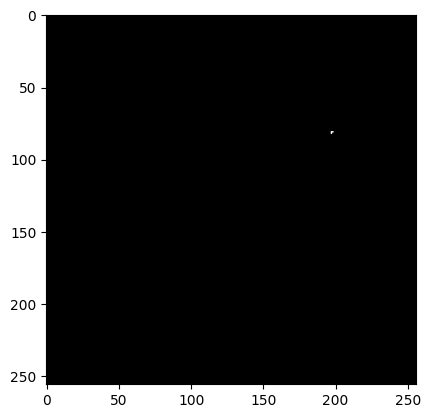

In [ ]:
plt.imshow(get_mask_arr(f'{BASE}/train_mask/train_mask_2.tif'))

(256, 256, 10)


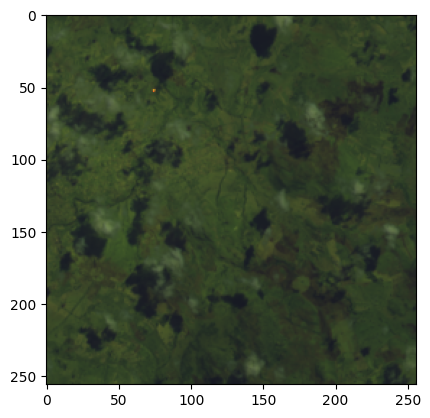

In [ ]:
plt.imshow(get_img_test(f'{BASE}/test_img/test_img_2.tif'))

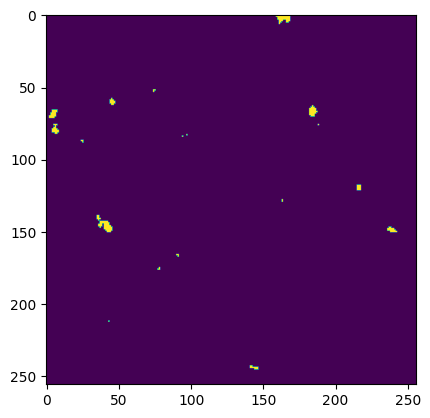

In [ ]:
plt.imshow(get_img_762bands(f'{BASE}/test_img/test_img_2.tif'))

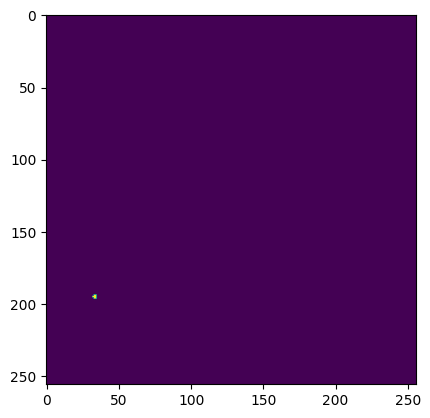

In [ ]:
plt.imshow(y_pred_dict['test_img_3.tif'])

In [ ]:
np.unique(y_pred_dict['test_img_3.tif'])

array([0, 1], dtype=uint8)

In [ ]:
import joblib
s = joblib.load(f"{BASE}/y_pred-2.pkl")

In [ ]:
s['test_img_0.tif'].shape

(256, 256)

In [ ]:
np.where(y_pred_dict['test_img_3.tif'] == 1)

(array([194, 194, 195, 195, 195, 196, 196]),
 array([33, 34, 32, 33, 34, 33, 34]))